In [15]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image

from network.mynetwork import Unet
from loss.loss import CLIPLoss
from utils.func import get_features,vgg_normalize

import time

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

lr1 = 0.0001
lr2 = 0.0002
model = Unet(device).to(device)
# model = Unet().to(device)
cliploss = CLIPLoss(device)
mseloss = torch.nn.MSELoss()
# vgg = torchvision.models.vgg19(pretrained=True).features.to(device)
# for x in vgg.parameters():
#     x.requires_grad = False

topil = transforms.ToPILImage()
topic = transforms.ToTensor()

dir_lambda = 500
content_lambda = 150
patch_lambda = 9000
norm_lambda = 0.002
gol_lambda = 300

In [17]:
loss_li = []


In [18]:
def train(iteration1, iteration2, pic, source, target, path):
    input = pic

    # pic_f = get_features(vgg_normalize(pic), vgg)

    opt = optim.Adam(model.parameters(), lr=lr1)
    for i in range(iteration1):
        opt.zero_grad()
        neo_pic = model(input)
        loss = mseloss(pic, neo_pic) * 1

        # loss = 0
        # neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        # loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        # loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)

        loss.backward()
        opt.step()

        print("iter:", i + 1, "loss:", loss.item())

        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 50) == 0:
        #     pil.save(f"./pic1/{(i + 1) // 50}.jpg")


    # torch.save(model,'unet.pth')

    # model = torch.load('unet.pth')

    # pic_f = get_features(vgg_normalize(pic),vgg)

    opt = optim.Adam(model.parameters(), lr=lr2)
    for i in range(iteration2):


        opt.zero_grad()
        neo_pic = model(input)

        dir_loss = 0
        dir_loss += cliploss.forward_dir(pic, source, neo_pic, target)

        gol_loss = 0
        # gol_loss += cliploss.forward_gol(pic, source, neo_pic, target)

        content_loss = 0
        # neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        # content_loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        # content_loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)

        patch_loss = 0
        patch_loss += cliploss.forward_patch(pic, source, neo_pic, target)

        norm_loss = 0
        norm_loss += cliploss.get_image_prior_losses(neo_pic)

        loss = dir_loss * dir_lambda + \
               content_loss * content_lambda + \
               patch_loss * patch_lambda + \
               norm_loss * norm_lambda + \
               gol_loss * gol_lambda

        loss.backward()
        opt.step()

        loss_li.append(loss.item())

        print("iter:", i + 1, "loss:", loss.item())


        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 10) == 0:
        #     pil.save(f"./pic2/{(i + 1) // 10}.jpg")

    neo_pic = model(input)
    pil = topil(neo_pic.squeeze(0).cpu())
    # pil.save(f"{source}-{target}.jpg")
    pil.save(path)


In [19]:
pil = Image.open(f"source_pic/boat.jpg")
pil = transforms.Resize(size=(512, 512), interpolation=Image.BICUBIC)(pil)
pic = topic(pil).unsqueeze(0).to(device)
# pic = torch.ones(1, 3, 512, 512).to(device)
pic.requires_grad = False

source = "photo"
target = "Neon light"
path = "result1.jpg"

start = time.time()
train(100, 100, pic, source, target, path)
end = time.time()
usetime = end - start
print(f"usetime: {usetime}")

# 186.4968602657318


iter: 1 loss: 0.08357506990432739
iter: 2 loss: 0.0663820207118988
iter: 3 loss: 0.05567575618624687
iter: 4 loss: 0.04792500287294388
iter: 5 loss: 0.041854213923215866
iter: 6 loss: 0.03681118041276932
iter: 7 loss: 0.032482799142599106
iter: 8 loss: 0.028906604275107384
iter: 9 loss: 0.02596283331513405
iter: 10 loss: 0.02349185012280941
iter: 11 loss: 0.021377183496952057
iter: 12 loss: 0.019544219598174095
iter: 13 loss: 0.01793944090604782
iter: 14 loss: 0.01651529222726822
iter: 15 loss: 0.015240630134940147
iter: 16 loss: 0.01409788429737091
iter: 17 loss: 0.013075698167085648
iter: 18 loss: 0.012162859551608562
iter: 19 loss: 0.011347323656082153
iter: 20 loss: 0.010617240332067013
iter: 21 loss: 0.009962786920368671
iter: 22 loss: 0.009373294189572334
iter: 23 loss: 0.00884031131863594
iter: 24 loss: 0.008357533253729343
iter: 25 loss: 0.007919094525277615
iter: 26 loss: 0.007520634215325117
iter: 27 loss: 0.007157725282013416
iter: 28 loss: 0.006826191674917936
iter: 29 loss

In [20]:
with open(file = "neo.txt", mode = "w") as file:
    for i in loss_li:
        file.write(str(i)+" ")


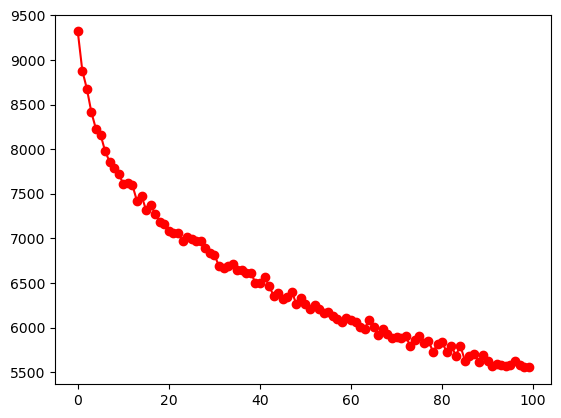

In [21]:
import matplotlib.pyplot as plt

x = [i for i in range(100)]
plt.plot(x,loss_li,color="red",marker="o")